# Multistep prediction aproach

1. Direct Multi-step Forecast Strategy
The direct method involves developing a separate model for each forecast time step.

Example:

    prediction(t+1) = model1(obs(t-1), obs(t-2), ..., obs(t-n))
    prediction(t+2) = model2(obs(t-2), obs(t-3), ..., obs(t-n))


2. Recursive Multi-step Forecast
The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.

Example:

    prediction(t+1) = model(obs(t-1), obs(t-2), ..., obs(t-n))
    prediction(t+2) = model(prediction(t+1), obs(t-1), ..., obs(t-n))


3. Direct-Recursive Hybrid Strategies
The direct and recursive strategies can be combined to offer the benefits of both methods.

For example, a separate model can be constructed for each time step to be predicted, but each model may use the predictions made by models at prior time steps as input values.

Example:

    prediction(t+1) = model1(obs(t-1), obs(t-2), ..., obs(t-n))
    prediction(t+2) = model2(prediction(t+1), obs(t-1), ..., obs(t-n))
    
    
4. Multiple Output Strategy
The multiple output strategy involves developing one model that is capable of predicting the entire forecast sequence in a one-shot manner.

Example:

	prediction(t+1), prediction(t+2) = model(obs(t-1), obs(t-2), ..., obs(t-n))

## Forcasting problems
1. Need recompute features dependent on predictions (lags, diffs, windows stitstics, other forecasts)
2. Need predict merged by date features

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
import warnings

In [3]:
data = pd.read_excel('../../data/3/data/2010_2020.xlsx')

In [4]:
data.head()

,country,datetime,product,count,mass
0,Корея,2010-01-01,EMS,4906,40985.44
1,Китай,2010-01-01,EMS,3084,37442.36
2,Соединенные Штаты Америки,2010-01-01,EMS,3537,31446.95
3,Соединенные Штаты Америки,2010-01-01,EMS,3615,31248.04
4,Израиль,2010-01-01,EMS,1375,25132.08


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307756 entries, 0 to 307755
Data columns (total 5 columns):
country     307734 non-null object
datetime    307756 non-null datetime64[ns]
product     307756 non-null object
count       307756 non-null int64
mass        307756 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 11.7+ MB


In [6]:
groupped_data = data.groupby('datetime').sum()
month_resampled = groupped_data.resample('M').sum()

In [7]:
mass = month_resampled[['mass']]
count = month_resampled[['count']]

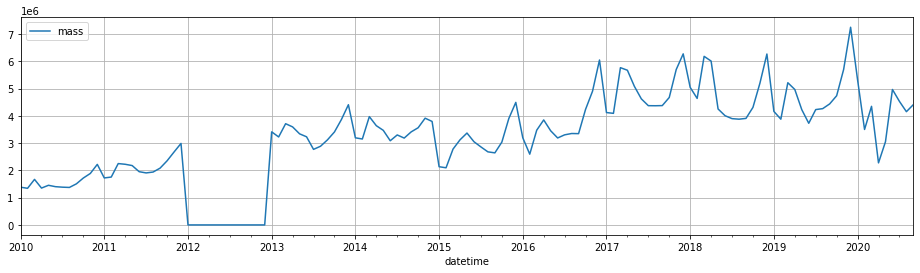

In [8]:
mass.plot(figsize=(16,4))
plt.grid()
plt.show()

In [9]:
mass = mass.replace(0, np.nan).interpolate()

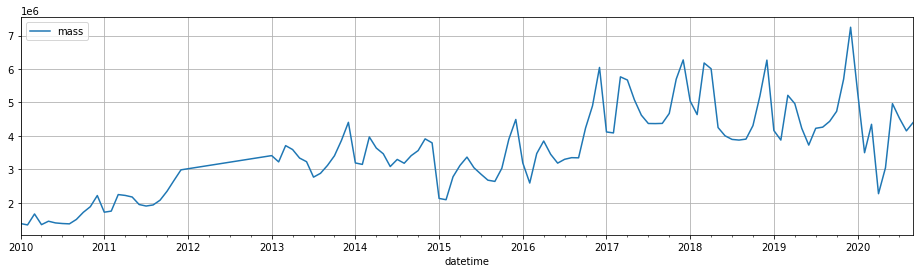

In [10]:
mass.plot(figsize=(16,4))
plt.grid()
plt.show()

In [14]:
row_data = mass.rename(columns={'mass':'target'})

## 0. Generate features

In [15]:
def generate_feature(row_data, n_lags=12, calendar=None):
    data = row_data.copy()
    
    # add lags and diff
    for i in range (1, n_lags + 1):
        data[f'lag_{i}'] = data['target'].shift(i)
        data[f'diff_{i}']  = data['target'].diff(i)
    
    # append calendar data
    if calendar != None:
        data = pd.merge(data, calendar)
        
    return data.dropna()

## 1. Direct multistep

In [16]:
warnings.simplefilter("ignore")
data = generate_feature(row_data, n_lags=12)

# datasets for learning all models
X = data.drop(columns='target')
targets = {}
predict_peroid = 60
for i in range(predict_peroid):
    # shift target relevant X
    targets[i] = data['target'].shift(i * (-1))
    
# learn model on each forecast step
models = {}

for i in range(predict_peroid):
    # create model
    model = Lasso()
    # fit model
    if i == 0:
        model.fit(X, targets[i])
    
    else:
        model.fit(X[:-i], targets[i][:-i])
    # add model to models dict
    models[i] = model
    
    
# predict
y_pred = []
for i in range(predict_peroid):
    y_pred.append(models[i].predict(X.iloc[[-1]])[0])

    
index=pd.date_range(start=X.index[-1], periods=predict_peroid + 1 , freq='M')[1:]
future_df = pd.DataFrame(y_pred, 
                         index=index,
                         columns=['prediction'])    

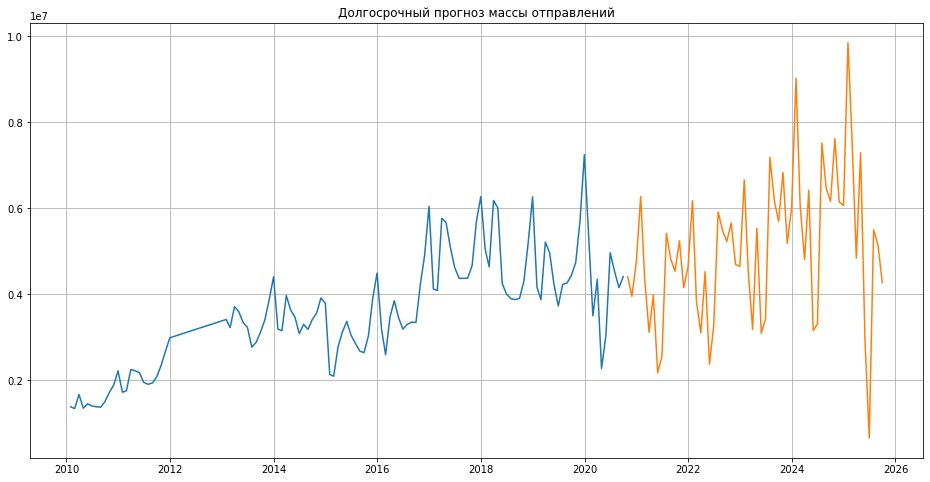

In [54]:
# 12 steps fit window
plt.figure(figsize=(16,8))
plt.plot(row_data[['target']])
plt.plot(future_df)
plt.title("Долгосрочный прогноз массы отправлений")
plt.grid()

## 2. Recursive multistep

In [264]:
# datasets for learning model
# row data - contain only target
# data - contain target lags, diff and calendar feature so we can recompute feature for prediction
data = generate_feature(row_data, n_lags=24)

X = data.drop(columns='target')
y = data['target'] 

# create model
model = Lasso()
# fit model for preditc T+1
model.fit(X, y)

Lasso()

In [265]:
# predict 
predictions = []

future_row_data = row_data.copy()
X_future = X.copy()

predict_peroid = 48
index = pd.date_range(start=X_future.index[-1], periods=predict_peroid + 1 , freq='M')[1:]

for i, idx in zip(range(predict_peroid), index):
    
    # predict T+1+i step
    y_pred = model.predict(X_future.iloc[[-1]])
    predictions.append(y_pred)
    
    # append  T+1+i prediction to other observations
    future_row_data = future_row_data.append(pd.Series(y_pred, index=['target'], name=idx))
    
    # generate features
    future_data = generate_feature(future_row_data, n_lags=24)
    X_future = future_data.drop(columns='target')

In [266]:
future_df = pd.DataFrame(predictions, 
                         index=pd.date_range(start=X.index[-1], periods=predict_peroid + 1 , freq='M')[1:],
                         columns=['prediction'])

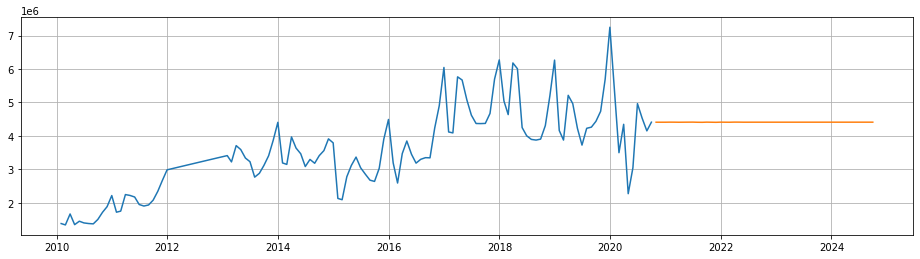

In [267]:

plt.figure(figsize=(16,4))
plt.plot(row_data[['target']])
plt.plot(future_df)
plt.grid()

## 3. Direct-Recursive Hybrid Strategies

In [261]:
# datasets for learning model
# row data - contain only target
# data - contain target lags, diff and calendar feature so we can recompute feature for prediction
# datasets for learning all models

# learn model on each forecast step
models = {}
targets = {}

predict_peroid = 48

index = pd.date_range(start=X.index[-1], periods=predict_peroid + 1 , freq='M')[1:]

# predict 
predictions = []

future_row_data = row_data.copy()
future_data = generate_feature(row_data, n_lags=24)
X_future = future_data.drop(columns='target')

for i in range(predict_peroid):
    # set_target
    targets[i] = future_data['target']
    
    # create model
    model = Lasso()
    
    # fit model
    model.fit(X_future, targets[i])
    
    # add model to models dict
    models[i] = model
    
    # predict T+1 step
    y_pred = model.predict(X_future.iloc[[-1]])
    predictions.append(y_pred)
    
    # append prediction to other observations
    future_row_data = future_row_data.append(pd.Series(y_pred, index=['target'], name=idx))
    
    # gerate features
    future_data = generate_feature(future_row_data)
    X_future = future_data.drop(columns='target')

In [247]:
X_future.iloc[[-1]]

,lag_1,diff_1,lag_2,diff_2,lag_3,diff_3,lag_4,diff_4,lag_5,diff_5,...,lag_20,diff_20,lag_21,diff_21,lag_22,diff_22,lag_23,diff_23,lag_24,diff_24
datetime,,,,,,,,,,,,,,,,,,,,,
2024-09-30,4.411696e+06,19.790731,4.411677e+06,39.6405,4.411657e+06,59.404723,4.411637e+06,78.841176,4.411617e+06,98.934106,...,4.411316e+06,399.960407,4.411299e+06,417.476098,4.411283e+06,432.964893,4.411261e+06,454.71858,4.411240e+06,476.436962


In [262]:
future_df = pd.DataFrame(predictions, 
                         index=pd.date_range(start=X.index[-1], periods=predict_peroid + 1 , freq='M')[1:],
                         columns=['prediction'])

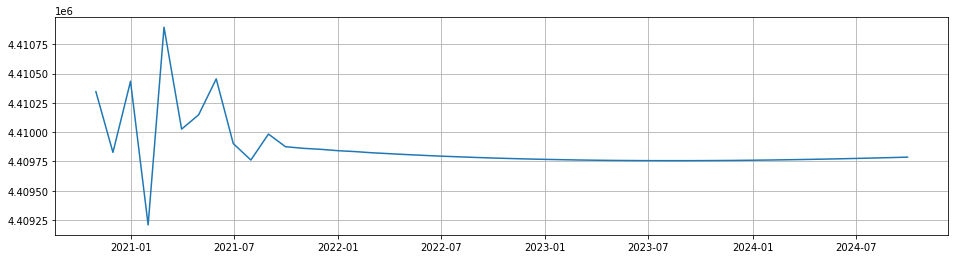

In [263]:
plt.figure(figsize=(16,4))
#plt.plot(future_row_data[['target']])
plt.plot(future_df)
plt.grid()

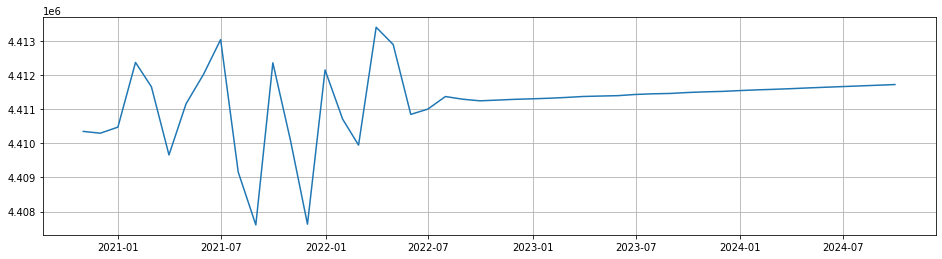

In [268]:
plt.figure(figsize=(16,4))
#plt.plot(future_row_data[['target']])
plt.plot(future_df)
plt.grid()

In [1]:
# построение иерархической модели для предсказания пользовательской активности / потока (source/sink)
 

In [3]:
# Уровни агрегации сверху вниз
# 1. Всего продаж/отправок в отделение(магазин)/часть города(кластер отделений/магазинов)/город/регион)
# 2. Всего продаж/отправок по направлениям "куда" отделение(магазин)/часть города(кластер отделений/магазинов)
# /город/регион)
# 3. Всего продаж/отправок по направлениям "куда" по продуктам
# 4. 
# 2. Активность на уровне локаций - количество трансзакций на уровне локации на уровень района поднимается 
# как сумма прогнозов
#
#
#
#
#
#

In [1]:
# 3. Активность на уровне индивидума - вероятность совершения трансзакции